# Wie breit sind Wiens Fahrrad-Einbahnen?

In Wien gibt es immer noch viele Einbahnen die nicht in beide Richtungen beradelt werden dürfen.
Warum öffnet die Stadt diese nicht, liegt es an der Fahrbahnbreite?
Wie breit sind diese Einbahnen?

Um diese Fragen zu beantworten brauchen wir:

- Fahrrad-Einbahnstraßen
- Fahrbahnflächen

Die Fahrrad-Einbahnstraßen finden sich im [GIP (Graphenintegrations-Platform)](https://www.data.gv.at/datasets/3fefc838-791d-4dde-975b-a4131a54e7c5), dem digitalen Verkehrsgraphen der öffentlichen Hand für ganz Österreich.
Die verlinkte Datensammlung umfasst allerhand Zeug, uns interessiert nur das _GIP Network_, das eigentliche Verkehrsnetz.
Auch das besteht aus mehreren Layers, die Infos die wir brauchen liegen in _GIP_LINKNETZ_OGD_.

Fahrrad-Einbahnen sind all jene Straßen in Wien die:

- KFZ nur in eine Richtung befahren dürfen (`ONEWAY_CAR = 0 OR ONEWAY_CAR = 1`)
- Radler:innen nur in eine Richtung befahren dürfen (`ONEWAY_BK = 0 OR ONEWAY_BK = 1`).  
  Anstatt die für Fahrräder geöffneten Einbahnen (`ONEWAY_BK = 2`) rauszufiltern taggen wir sie nur.
  So berechnen wir in Folge auch deren Breite und können sie statistisch untersuchen.

Schließlich filtern wir jene Straßen die ein Tempolimit von über 30 km/h haben (`VMAX_CAR_T <= 30 AND VMAX_CAR_B <= 30`).
Bei höheren Geschwindigkeiten möcht ich zumindest nicht gegen die Einbahn radeln.

Caveat: Leider fehlen auf einigen Straßen die Tempolimits.
Diese Straßen berücksichtigen wir nicht (`VMAX_CAR_T != -1 OR VMAX_CAR_B != -1`).


/Users/eli/Documents/coding/visualisierungen/wie-breit-sind-wiens-fahrrad-einbahnen/venv/lib/python3.13/site-packages/geopandas/geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


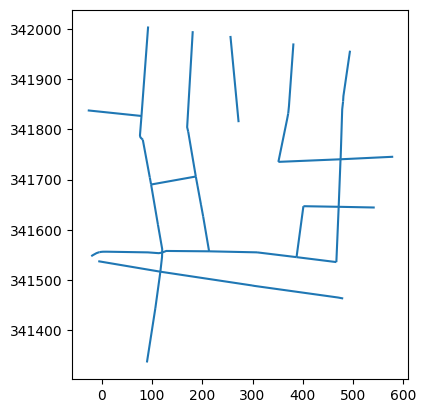

In [19]:
import geopandas as gpd
from shapely.geometry import box

gip_network = gpd.read_file("datasets/gip-network.gpkg", layer="GIP_LINKNETZ_OGD")
einbahnen = gip_network[
    ((gip_network["ONEWAY_CAR"] == 0) | (gip_network["ONEWAY_CAR"] == 1))
    & (gip_network["VMAX_CAR_T"] <= 30)
    & (gip_network["VMAX_CAR_B"] <= 30)
    & ((gip_network["VMAX_CAR_T"] != -1) | (gip_network["VMAX_CAR_B"] != -1))
]
einbahnen["is_open_for_bikes"] = einbahnen["ONEWAY_BK"] == 2
einbahnen = einbahnen.to_crs(epsg=31256)

landesgrenze_wien = gpd.read_file("datasets/landesgrenze-wien.json")
landesgrenze_wien = landesgrenze_wien.to_crs(epsg=31256)
einbahnen = gpd.clip(einbahnen, landesgrenze_wien)

einbahnen = einbahnen.explode(index_parts=True).reset_index(drop=True)
einbahnen = einbahnen[["geometry", "is_open_for_bikes"]]

yppenplatz_x, yppenplatz_y = 233.67, 341659.45
yppenplatz_bbox = box(
    yppenplatz_x - 250, yppenplatz_y - 250, yppenplatz_x + 250, yppenplatz_y + 250
)
ax = einbahnen[einbahnen.intersects(yppenplatz_bbox)].plot()

Mit Fahrbahnflächen meinen wir wirklich nur die befahrbahren Bereiche.
Parkplätze, Verkehrsinseln, etc. verengen die Straße und zählen nicht zur Fahrbahn.

Die Fahrbahnflächen können wir über die [FMZK (Flächen-Mehrzweckkarte)](https://www.data.gv.at/datasets/7cf0da04-1f77-4321-929e-78172c74aa0b) der Stadt Wien ermitteln.

Folgende FMZK-Klassen betrachten wir als befahrbar:

- Fahrbahn
- Zebrastreifen
- Schienebereich
- Gleiskörper
- Fahrbahnschwelle

Die Schienenbereiche und Gleiskörper umfassen Bim-Gleise, aber auch Zug- und U-Bahn-Gleise.
Letztere sind natürlich nicht befahrbar, verlaufen aber nicht entlang der Fahrrad-Einbahnen - wir müssen sie nicht rausfiltern.

Caveats:

- Fahrbahnflächen die von Überbauungen (`F_KLASSE = 12`) überdeckt sind fehlen.
  Die FMZK bildet nur eine Ebene ab, wir wissen nicht wie es unter der Überbauung aussieht.
- Nicht straßenmarkierte Parkflächen in Siedlungsstraßen sind nicht in der FMZK vermerkt.
  Es resultieren hier also evtl. zu breite Fahrbahnflächen.


<Axes: >

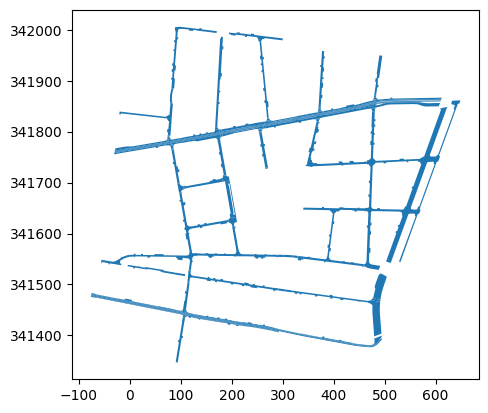

In [20]:
fmzk = gpd.read_file("datasets/fmzk.gpkg")
fahrbahnflaechen = fmzk[
    (fmzk["F_KLASSE"] == 21)  # Fahrbahn
    | (fmzk["F_KLASSE"] == 30)  # Zebrastreifen
    | (fmzk["F_KLASSE"] == 27)  # Schienebereich
    | (fmzk["F_KLASSE"] == 28)  # Gleiskörper
    | (fmzk["F_KLASSE"] == 32)  # Fahrbahnschwelle
]
fahrbahnflaechen = fahrbahnflaechen.reset_index(drop=True)
fahrbahnflaechen = fahrbahnflaechen.to_crs(epsg=31256)
fahrbahnflaechen = fahrbahnflaechen[["geometry"]]

fahrbahnflaechen[fahrbahnflaechen.intersects(yppenplatz_bbox)].plot()

Wir haben jetzt also:

- Linestrings der Fahrrad-Einbahnen
- Polygone der befahrbaren Straßenflächen

Wie messen wir nun die Fahrbahnbreite entlang der Einbahnen?

1. Einbahn-Linestrings mit 1-Meter-Schrittweite abtasten
2. durch jeden Abtastpunkt eine 20 Meter lange und zu dem aktuellen Linestring-Segment senkrechte (_perpendicular_) Linie ziehen
3. für jede senkrechte Linie $l_p$:
   1. Fahrbahnflächen-Polygone finden die sich mit $l_p$ überschneiden
   2. diese Polygone zu einem Polygon $F_p$ verschmelzen
   3. Liniensegmente $S_p$ von $l_p$ berechnen die sich mit $F_o$ überlappen.  
      _NB: $F_p$ kann trotz Verschmelzung aus mehreren isolierten Polygonen bestehen, deshalb kann es auch mehrere Liniensegmente $S_p$ geben._
   4. Aus $S_p$ die längste Linie $s_p$ wählen die maximal 0.5 m vom Schnittpunkt der Einbahn-Linie mit $l_p$, also vom Abtastpunkt, entfernt ist.  
      _Erklärung: Aufgrund von Ungenauigkeiten im Datenset der Einbahnlinien verlaufen manche Linienabschnitte knapp an den Fahrbahnflächen vorbei.
      Mit dieser Heuristik messen wir auch die Fahrbahnbreite solcher Einbahnlinien._
4. die Mindestbreite einer Einbahn ist die Länge der kürzesten zu dieser Einbahn gehörenden $s_p$


In [21]:
from shapely.geometry import LineString, Point
import numpy as np
from tqdm import tqdm


tqdm.pandas()


def sample(line, step):
    distances = np.arange(0, line.length + step, step)
    return [line.interpolate(d) for d in distances]


def get_segments(line):
    coords = list(line.coords)
    return [LineString([coords[i], coords[i + 1]]) for i in range(len(coords) - 1)]


def get_perpendicular_line(point, segment, length):
    coords = np.array(segment.coords)
    dx, dy = coords[1] - coords[0]
    norm = np.hypot(dx, dy)
    px, py = -dy / norm, dx / norm
    p1 = Point(point.x + px * length / 2, point.y + py * length / 2)
    p2 = Point(point.x - px * length / 2, point.y - py * length / 2)
    return LineString([p1, p2])


perpendiculars = []
for idx, line in tqdm(einbahnen.iterrows(), total=len(einbahnen)):
    for segment in get_segments(line.geometry):
        points = sample(segment, step=1)
        for point in points:
            perpendiculars.append(
                {
                    "einbahn_idx": idx,
                    "point": point,
                    "geometry": get_perpendicular_line(point, segment, length=20),
                }
            )

perpendiculars = gpd.GeoDataFrame(perpendiculars, crs=einbahnen.crs)

100%|██████████| 11649/11649 [00:32<00:00, 356.81it/s]


Jetzt die relevanten Polygone finden und verschmelzen:


In [22]:
from shapely import union_all


perpendiculars = gpd.sjoin(
    perpendiculars, fahrbahnflaechen, how="left", predicate="intersects"
)
perpendiculars = perpendiculars.rename(columns={"index_right": "fahrbahnflaechen_idx"})


def merge_fahrbahnflaechen(idxs):
    idxs = idxs.dropna().astype(int).to_numpy()
    if len(idxs) == 0:
        return None
    elif len(idxs) == 1:
        return fahrbahnflaechen.geometry.iloc[idxs[0]]
    return union_all(fahrbahnflaechen.geometry.take(idxs))


perpendiculars["fahrbahnflaechen"] = (
    perpendiculars["fahrbahnflaechen_idx"]
    .groupby(perpendiculars.index)
    .progress_apply(merge_fahrbahnflaechen)
)

100%|██████████| 872711/872711 [01:35<00:00, 9181.00it/s] 


Dann Einbahn-Senkrechte und Fahrbahnflächen überschneiden und das (wahrscheinlich) richtige Überschneidungssegment wählen:


In [23]:
from shapely.geometry import LineString, MultiLineString


def get_longest_segment(geom, point, max_distance):
    if geom is None or geom.is_empty or point is None:
        return None

    segments = []
    if isinstance(geom, LineString):
        segments = [geom]
    elif isinstance(geom, MultiLineString):
        segments = list(geom.geoms)

    segments = [seg for seg in segments if seg.distance(point) <= max_distance]

    if not segments:
        return None

    return max(segments, key=lambda s: s.length)


perpendiculars["fahrbahnflaechen_intersection"] = perpendiculars.progress_apply(
    lambda row: row.geometry.intersection(row["fahrbahnflaechen"]), axis=1
)

perpendiculars["fahrbahnflaechen_intersection"] = perpendiculars.progress_apply(
    lambda row: get_longest_segment(
        row["fahrbahnflaechen_intersection"], row["point"], max_distance=0.5
    ),
    axis=1,
)

100%|██████████| 995685/995685 [00:10<00:00, 94479.25it/s] 


Schließlich die minimale Breite jeder Einbahn berechnen:


In [24]:
perpendiculars["fahrbahnflaechen_intersection_length"] = perpendiculars[
    "fahrbahnflaechen_intersection"
].length.astype(float)

einbahnen["minimum_width"] = einbahnen.index.map(
    perpendiculars.groupby("einbahn_idx")["fahrbahnflaechen_intersection_length"].min()
)

einbahnen["median_width"] = einbahnen.index.map(
    perpendiculars.groupby("einbahn_idx")[
        "fahrbahnflaechen_intersection_length"
    ].median()
)

Jetzt können wir uns ansehen wie breit die bereits für Fahrräder geöffneten Einbahnen im Vergleich zu den noch nicht geöffneten sind.


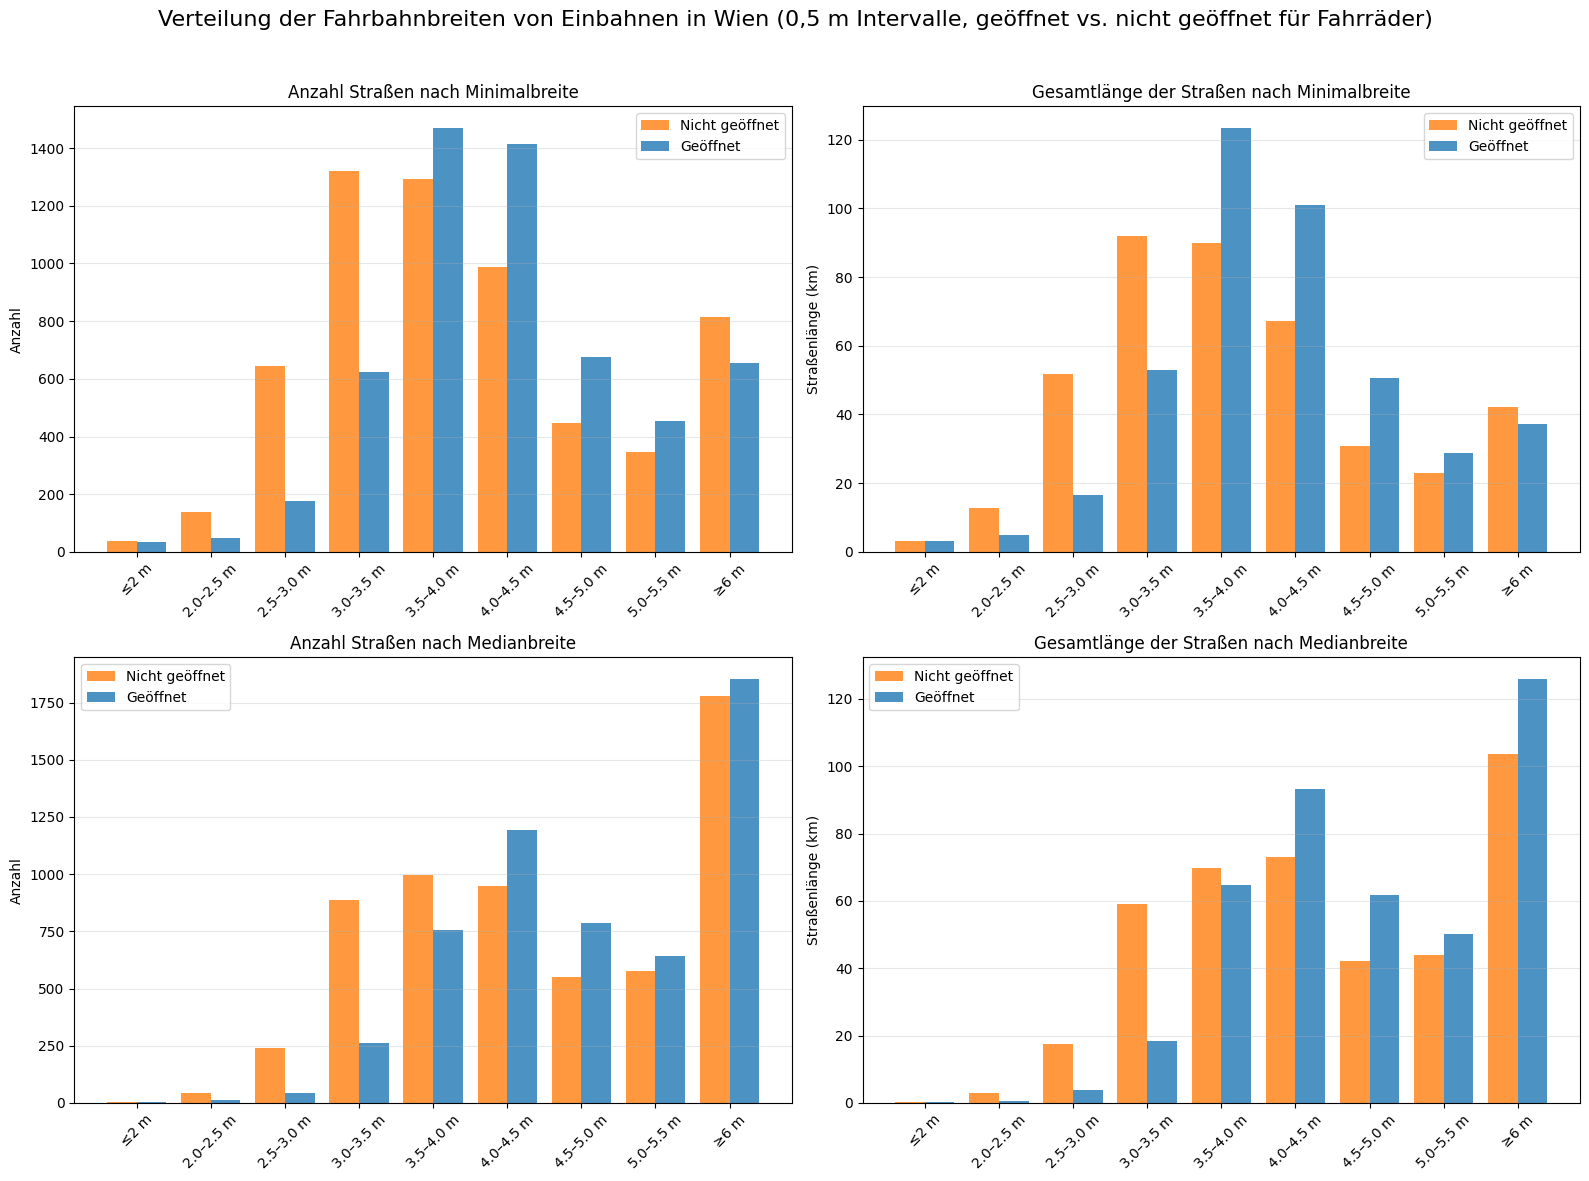

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

bins = [0, 2] + list(np.arange(2.5, 6.0, 0.5)) + [np.inf]
color_closed = "#ff7f0e"
color_open = "#1f77b4"
bar_width = 0.4

einbahnen["length_m"] = einbahnen.geometry.length


def agg_counts_lengths(df, colname, bins):
    widths = pd.to_numeric(df[colname], errors="coerce")
    valid = df[widths.notna()].copy()
    widths = widths[widths.notna()]
    cats = pd.cut(widths, bins=bins, right=False)
    counts = valid.groupby(cats, observed=False).size()
    lengths = valid.groupby(cats, observed=False)["length_m"].sum() / 1000
    return counts, lengths, cats.cat.categories


def make_labels(categories):
    labels = []
    for interval in categories:
        if interval.left == 0:
            labels.append("≤2 m")
        elif interval.right == np.inf:
            labels.append("≥6 m")
        else:
            labels.append(f"{interval.left:.1f}–{interval.right:.1f} m")
    return labels


def plot_side_by_side(ax, counts_closed, counts_open, labels, title, ylabel):
    x = np.arange(len(labels))
    ax.bar(
        x - bar_width / 2,
        counts_closed,
        width=bar_width,
        color=color_closed,
        alpha=0.8,
        label="Nicht geöffnet",
    )
    ax.bar(
        x + bar_width / 2,
        counts_open,
        width=bar_width,
        color=color_open,
        alpha=0.8,
        label="Geöffnet",
    )
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=45)
    ax.grid(axis="y", alpha=0.3)
    ax.legend()


opened = einbahnen[einbahnen["is_open_for_bikes"]]
closed = einbahnen[~einbahnen["is_open_for_bikes"]]

data = {}
for col in ["minimum_width", "median_width"]:
    counts_open, lengths_open, cats = agg_counts_lengths(opened, col, bins)
    counts_closed, lengths_closed, _ = agg_counts_lengths(closed, col, bins)
    labels = make_labels(cats)
    data[col] = {
        "counts_open": counts_open,
        "counts_closed": counts_closed,
        "lengths_open": lengths_open,
        "lengths_closed": lengths_closed,
        "labels": labels,
    }

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False)

plot_side_by_side(
    axes[0, 0],
    data["minimum_width"]["counts_closed"],
    data["minimum_width"]["counts_open"],
    data["minimum_width"]["labels"],
    "Anzahl Straßen nach Minimalbreite",
    "Anzahl",
)
plot_side_by_side(
    axes[0, 1],
    data["minimum_width"]["lengths_closed"],
    data["minimum_width"]["lengths_open"],
    data["minimum_width"]["labels"],
    "Gesamtlänge der Straßen nach Minimalbreite",
    "Straßenlänge (km)",
)
plot_side_by_side(
    axes[1, 0],
    data["median_width"]["counts_closed"],
    data["median_width"]["counts_open"],
    data["median_width"]["labels"],
    "Anzahl Straßen nach Medianbreite",
    "Anzahl",
)
plot_side_by_side(
    axes[1, 1],
    data["median_width"]["lengths_closed"],
    data["median_width"]["lengths_open"],
    data["median_width"]["labels"],
    "Gesamtlänge der Straßen nach Medianbreite",
    "Straßenlänge (km)",
)

plt.suptitle(
    "Verteilung der Fahrbahnbreiten von Einbahnen in Wien (0,5 m Intervalle, geöffnet vs. nicht geöffnet für Fahrräder)",
    fontsize=16,
)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

Das restliche Notebook bereitet Daten für die interaktive Kartendarstellung auf.


In [26]:
fahrrad_einbahnen = einbahnen[~einbahnen["is_open_for_bikes"]].drop(
    columns=["is_open_for_bikes"]
)
perpendiculars = perpendiculars[
    perpendiculars["einbahn_idx"].isin(fahrrad_einbahnen.index)
]

Zunächst alle Einbahnen und Einbahn-Senkrechten nach Mindestbreite bzw Länge einfärben.  
Werte <2.5m oder >4m gleich behandeln.  
Das untere Drittel der Colormap nicht verwenden da zu blass.


In [ ]:
import matplotlib.colors as mcolors

min_width = 2.5
max_value = 4.0
norm = mcolors.Normalize(vmin=min_width, vmax=max_value, clip=True)
cmap = plt.cm.Blues
cmap_offset = mcolors.LinearSegmentedColormap.from_list(
    "Blues_offset", cmap(np.linspace(0.3, 1, 256))
)
fahrrad_einbahnen["color"] = [
    mcolors.to_hex(cmap_offset(norm(w))) for w in fahrrad_einbahnen["minimum_width"]
]
perpendiculars["color"] = [
    mcolors.to_hex(cmap_offset(norm(w)))
    for w in perpendiculars["fahrbahnflaechen_intersection_length"]
]

Color-stops für die Legende:


In [28]:
for i in range(4):
    value = min_width + 0.5 * i
    color = mcolors.to_hex(cmap_offset(norm(value)))
    print(f"Breite {value:.2f}: {color}")

Breite 2.50: #b7d4ea
Breite 3.00: #60a7d2
Breite 3.50: #1d6cb1
Breite 4.00: #08306b


Wir wollen nicht alle Einbahn-Senkrechten visualisieren sondern nur jene die in ihrer Länge lokale Minima darstellen.  
Um die Zahl der lokalen Minima zu reduzieren runden wir die Längen der Senkrechten auf 10cm.  
Von den dabei entstehenden Talplateaus die Einbahn-Senkrechte in der Mitte des Plateaus wählen.  
Nur Einbahn-Senkrechten mit einer Länge von maximal 8 m und maximal eine Einbahn-Senkrechte alle 20m.


In [ ]:
def keep_local_minima(df, col, precision, min_spacing, max_value):
    df = df.dropna(subset=[col])
    if df.empty:
        return df

    qvals = (df[col] / precision).round().to_numpy()
    minima_idxs = []

    n = len(qvals)
    i = 0
    while i < n:
        plateau_start = i
        plateau_val = qvals[i]
        while i + 1 < n and qvals[i + 1] == plateau_val:
            i += 1
        plateau_end = i

        left = qvals[plateau_start - 1] if plateau_start > 0 else np.inf
        right = qvals[plateau_end + 1] if plateau_end < n - 1 else np.inf

        if plateau_val < left and plateau_val < right:
            middle = (plateau_start + plateau_end) // 2
            minima_idxs.append(middle)

        i += 1

    keep = []
    last_pos = -np.inf
    for pos in minima_idxs:
        if pos - last_pos >= min_spacing and qvals[pos] * precision <= max_value:
            keep.append(pos)
            last_pos = pos

    return df.iloc[keep]


perpendiculars = (
    perpendiculars.groupby("einbahn_idx", group_keys=False)
    .progress_apply(
        keep_local_minima,
        col="fahrbahnflaechen_intersection_length",
        precision=0.1,
        min_spacing=20,
        max_value=8,
    )
    .reset_index(drop=True)
)

100%|█████████▉| 6048/6053 [00:04<00:00, 1760.78it/s]/Users/eli/Documents/coding/visualisierungen/wie-breit-sind-wiens-fahrrad-einbahnen/venv/lib/python3.13/site-packages/tqdm/std.py:917: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return getattr(df, df_function)(wrapper, **kwargs)
100%|██████████| 6053/6053 [00:04<00:00, 1271.00it/s]


Die Länge in ein Label umwandeln


In [30]:
perpendiculars["fahrbahnflaechen_intersection_length"] = perpendiculars.apply(
    lambda row: f"{row['fahrbahnflaechen_intersection_length']:.1f} m", axis=1
)

CRS für Visualisierung setzen und Daten exportieren.


In [31]:
fahrrad_einbahnen.to_crs(4326).to_file(
    "web/datasets/einbahnen.geojson", driver="GeoJSON"
)
perpendiculars.set_geometry("fahrbahnflaechen_intersection").set_crs(31256).to_crs(
    4326
)[
    ["fahrbahnflaechen_intersection", "fahrbahnflaechen_intersection_length", "color"]
].to_file(
    "web/datasets/perpendiculars.geojson", driver="GeoJSON"
)

Als Grundkarte für die Visualisierung verwenden wir den [Wiener Straßengraph](https://www.data.gv.at/datasets/1039ed7e-97fb-435f-b6cc-f6a105ba5e09).


In [32]:
strassengraph = gpd.GeoDataFrame(
    geometry=gpd.read_file("datasets/strassengraph.json").geometry
)
strassengraph.to_file("web/datasets/strassengraph.geojson", driver="GeoJSON")